# Imports

In [1]:
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers

from src.datasets.pneumonia_detection_challenge import PneumoniaDetectionChallenge
from src.utils.schemes import Scheme
from src.utils.image import Image

# Dataset loading for training

In [2]:
IMAGE_SIZE = (256, 256)

In [3]:
pdc = PneumoniaDetectionChallenge(DATASET_PNEUMONIA_DETECTION_CHALLENGE_PATH, IMAGE_SIZE)

In [4]:
Scheme.dataset_info(pdc)

Train:
 - Normal: 15477
 - Pneumonia: 4536
Test:
 - Normal: 1558
 - Pneumonia: 1476
Val:
 - Normal: 16
 - Pneumonia: 4


In [5]:
x_train, y_train, _ = pdc.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = pdc.load_val_data()
x_val = x_val / 255.0

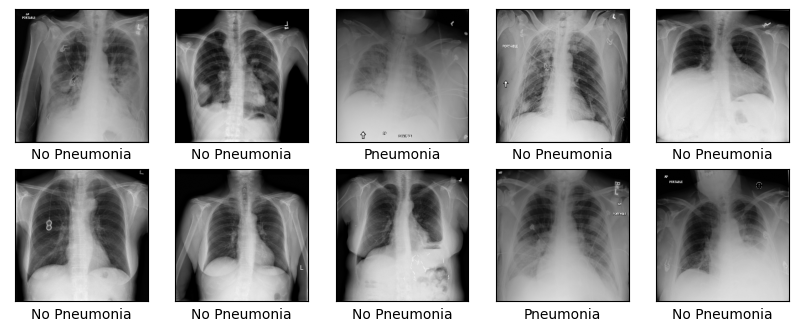

In [6]:
Scheme.labeled_images(x_train, y_train)

# Mdel definition

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(filters=8, activation='relu', kernel_size=3, padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=16, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=32, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       3

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       3

In [9]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])

# Model training

In [10]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=35)

Epoch 1/35
626/626 [==============================] - 31s 37ms/step - loss: 0.5026 - binary_accuracy: 0.7727 - precision: 0.4866 - recall: 0.0678 - val_loss: 0.4261 - val_binary_accuracy: 0.8500 - val_precision: 0.6667 - val_recall: 0.5000
Epoch 2/35
626/626 [==============================] - 19s 31ms/step - loss: 0.4370 - binary_accuracy: 0.7990 - precision: 0.6026 - recall: 0.3085 - val_loss: 0.3382 - val_binary_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.5000: 9s - loss: 0.4370 - binary_acc - ETA: 0s - loss: 0.4370 - binary_accuracy: 0.7990 - precision: 0.6025 - recall: 0.30
Epoch 3/35
626/626 [==============================] - 20s 31ms/step - loss: 0.4273 - binary_accuracy: 0.8052 - precision: 0.6230 - recall: 0.3149 - val_loss: 0.2847 - val_binary_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 4/35
626/626 [==============================] - 20s 31ms/step - loss: 0.4222 - binary_accuracy: 0.8103 - precision: 0.6239 - recall: 0.3906 - val_loss: 0.33

<Figure size 640x480 with 0 Axes>

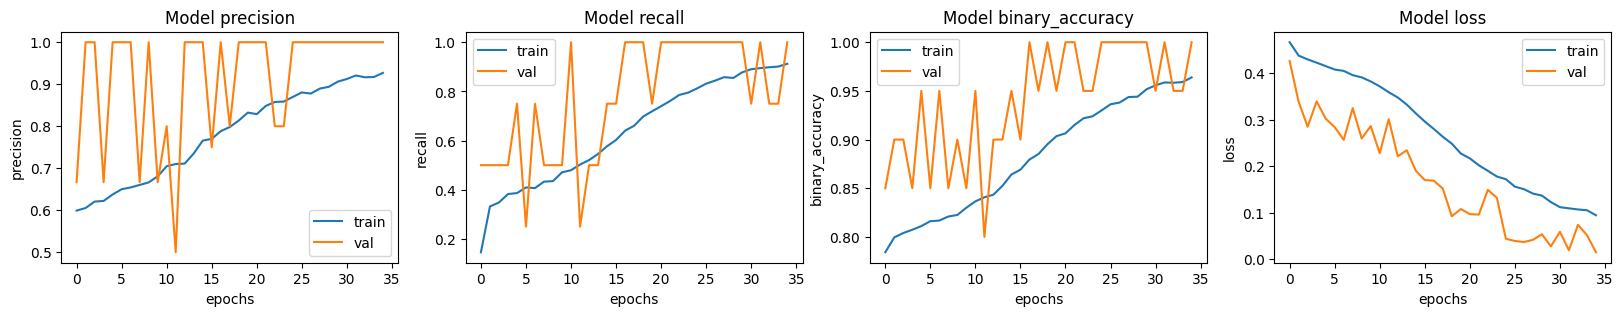

In [11]:
Scheme.training_graphs(history)

In [12]:
del x_train
del y_train

# Evaluating the model

In [13]:
x_test, y_test, images = pdc.load_test_data()
x_test = x_test / 255.0

In [14]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

95/95 [==============================] - 2s 16ms/step - loss: 2.4444 - binary_accuracy: 0.6711 - precision: 0.8128 - recall: 0.4207


In [15]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [16]:
images_index = [103, 117, 156, 353, 465, 1615, 1707, 1875, 1951, 2150]
images = [x_test[img] for img in images_index]
labels = [y_test[img] for img in images_index]
predicted_images = [predictions_rounded[img][0] for img in images_index]

Before explaining the images

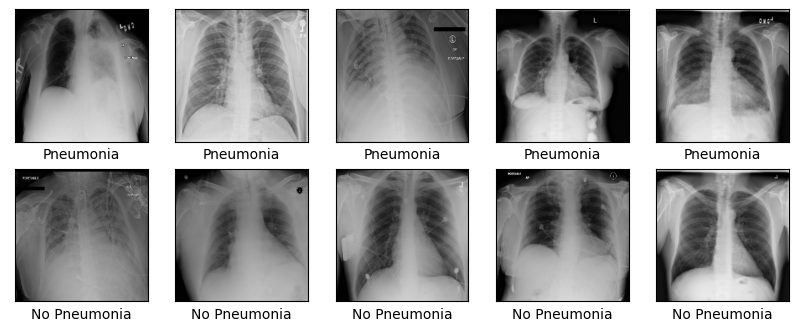

In [17]:
Scheme.labeled_images(images, labels)

Explain the images

In [18]:
explained_images = Image.explain(images, model, IMAGE_SIZE)

100%|██████████| 1000/1000 [00:06<00:00, 151.00it/s]


Green regions -> Supporting the predicted label

Red regions -> Against the predicted label

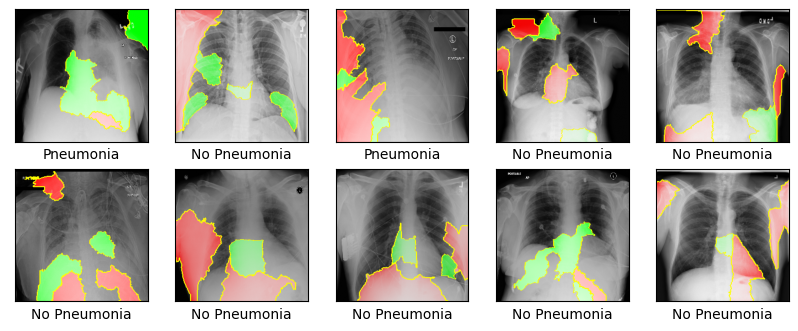

In [19]:
Scheme.labeled_images(explained_images, predicted_images)

<Figure size 640x480 with 0 Axes>

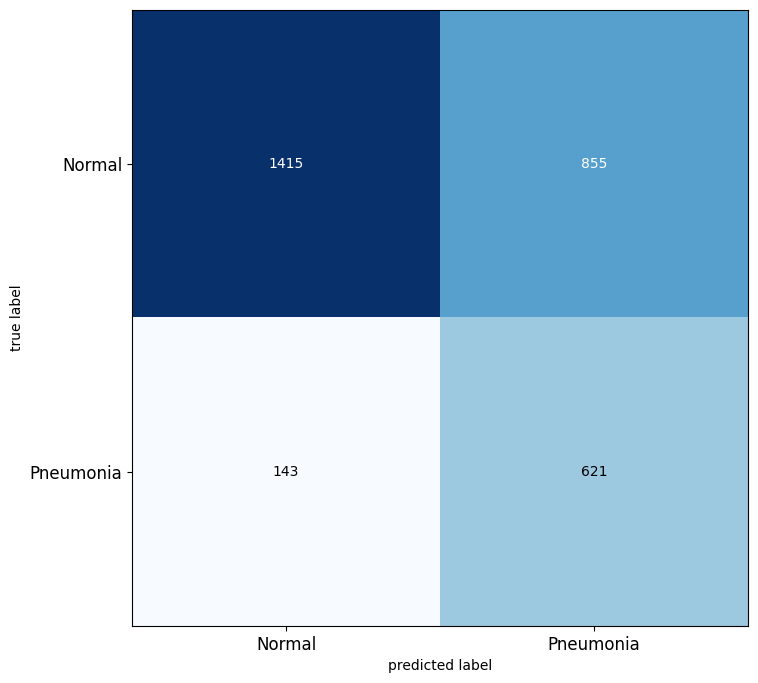

In [20]:
Scheme.confusion_matrix(predictions_rounded, pdc.get_test_df().diagnosis.to_numpy())